In [1]:
import pandas as pd
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error


# Загрузка, очистка и преобразование данных

Загрузка данных

In [2]:
df = pd.read_csv('PCPS_06-08-2023 20-05-34-68_timeSeries.csv')

In [3]:
print(df.transpose().columns)

RangeIndex(start=0, stop=412, step=1)


In [4]:
df = df[df["Unit Name"] == "Index"]

In [5]:
#Выбираем параметр, который будем исследовать.
choose_com = "PALUM"

#На сколько предсказываем
Ntest = 24

In [6]:
df2 = df.transpose()

In [7]:
df3 = df2.drop(["Country Name", "Commodity Name", "Country Code", "Unit Name", "Unit Code", "Attribute"], axis = 0)

In [8]:
df3.columns = df3.iloc[0]

In [9]:
df4 = df3.drop(["Commodity Code"], axis = 0)

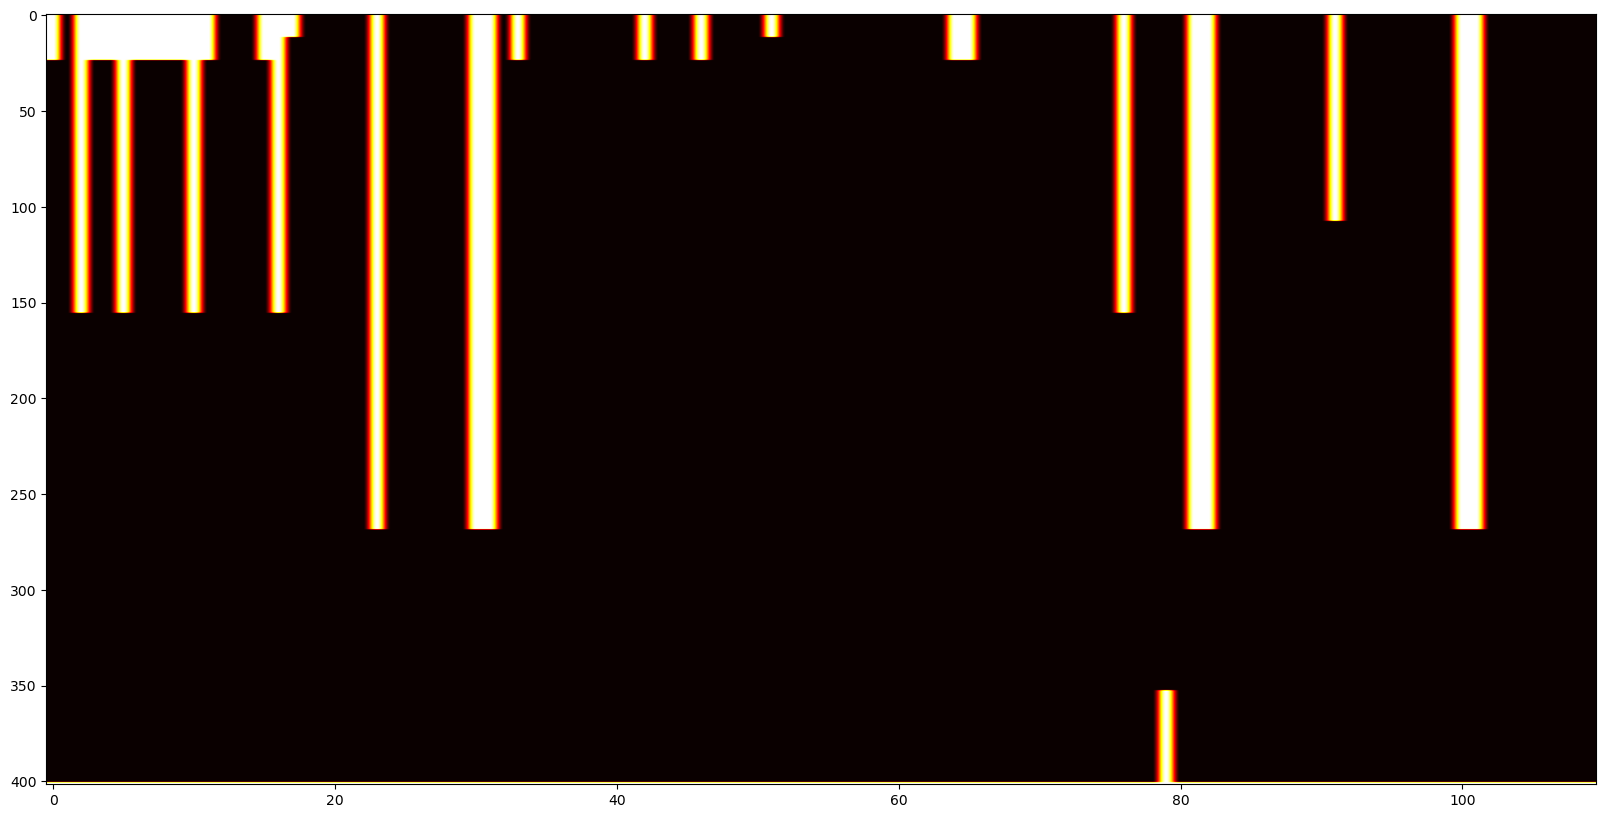

In [10]:
#visualize missing values
plt.rcParams["figure.figsize"] = (20, 10)
plt.imshow(df4.isnull(), cmap='hot', aspect='auto')
plt.show()

In [11]:
#Дропним пока колонки с missing values
df5 = df4.iloc[:-1]

In [12]:
df6 = df5.dropna(axis = 1)

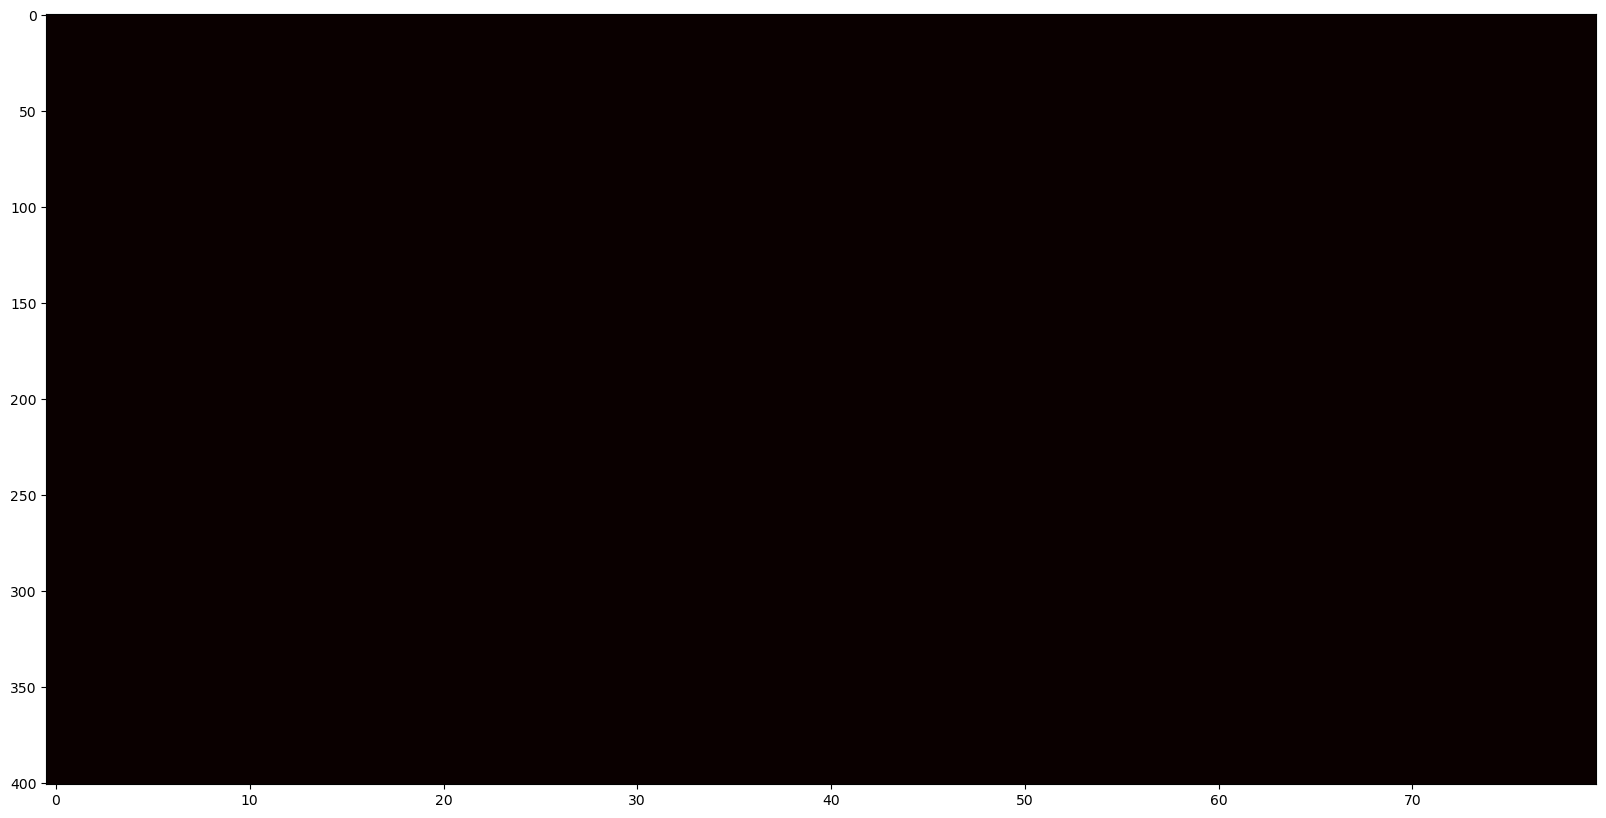

In [13]:
#visualize missing values
plt.rcParams["figure.figsize"] = (20, 10)
plt.imshow(df6.isnull(), cmap='hot', aspect='auto')
plt.show()

In [14]:
df6.columns

Index(['PPMETA', 'PBEVE', 'PCOAL', 'PRAWM', 'PCOALAU', 'PSHRI', 'PMAIZMT',
       'PUREA', 'PSOIL', 'PWHEAMT', 'PCOTTIND', 'PSUGAUSA', 'PTEAINDIA',
       'PTIN', 'PCOFFOTM', 'PDAP', 'PTEAMOM', 'PCOBA', 'PSUGA', 'PCOCO',
       'PSAWMAL', 'PRICENPQ', 'PWOOLF', 'PZINC', 'PSILVER', 'PMEAT', 'POLVOIL',
       'PLOGSK', 'POILWTI', 'PALUM', 'PTIMB', 'PPALLA', 'PPLAT', 'PBARL',
       'PGNUTS', 'PCOPP', 'PTEA', 'PBEEF', 'POILDUB', 'PVOIL', 'PSAWORE',
       'PPORK', 'PIORECR', 'PSUNO', 'PROIL', 'PLEAD', 'PCERE', 'PSORG',
       'PCOIL', 'PGOLD', 'PAPPLE', 'PLOGORE', 'PPOULT', 'PPOIL', 'PSUGAISA',
       'PSMEA', 'PLAMB', 'PTOMATO', 'PSALM', 'PHIDE', 'PSOYB', 'PGASO',
       'PNGASEU', 'PHARD', 'PURAN', 'PCOALSA', 'PSOFT', 'PSEAF', 'POILBRE',
       'PRUBB', 'PFSHMEAL', 'PWOOLC', 'PBANSOP', 'PORANG', 'PWOOL', 'PCOFF',
       'PCOFFROB', 'PHEATOIL', 'POATS', 'PNICK'],
      dtype='object', name='Commodity Code')

In [15]:
df7 = pd.DataFrame(df6[[choose_com]].iloc[:,0])
df7[choose_com] = df7[choose_com].astype(float)

In [16]:
#Вернем лог ретерн, то есть процент изменения

def log_ret(price):
  log_price = np.log(price)
  return log_price.diff()

In [17]:
df7['LogRet'] = log_ret(df7[[choose_com]])

In [18]:
Ntest = 24
train = df7.iloc[:-Ntest]
test = df7.iloc[-Ntest:]

In [19]:
df7.info()

<class 'pandas.core.frame.DataFrame'>
Index: 401 entries, 1990M1 to 2023M5
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PALUM   401 non-null    float64
 1   LogRet  400 non-null    float64
dtypes: float64(2)
memory usage: 9.4+ KB


In [20]:
train_idx = df7.index <= train.index[-1]
test_idx = df7.index > train.index[-1]

In [21]:
def plot_fit_and_forecast(result):
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.plot(df7["LogRet"], label='data')

  # plot the curve fitted on train set
    train_pred = result.fittedvalues
    ax.plot(train.index, train_pred, color='green', label='fitted')

  # forecast the test set
    prediction_result = result.get_forecast(Ntest)
    conf_int = prediction_result.conf_int()
    lower, upper = conf_int['lower ' + "LogRet"], conf_int['upper ' + "LogRet"]
    forecast = prediction_result.predicted_mean
    ax.plot(test.index, forecast, label='forecast')
    ax.fill_between(test.index, \
                  lower, upper, \
                  color='red', alpha=0.3)
    ax.legend()

# Графики автокорреляции

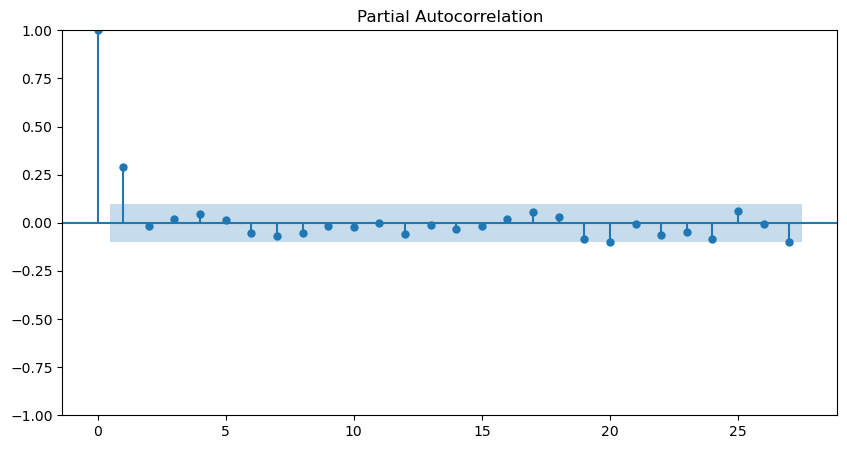

In [22]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

fig, ax = plt.subplots(figsize=(10, 5))
plot_pacf(df7['LogRet'].dropna(), ax=ax);



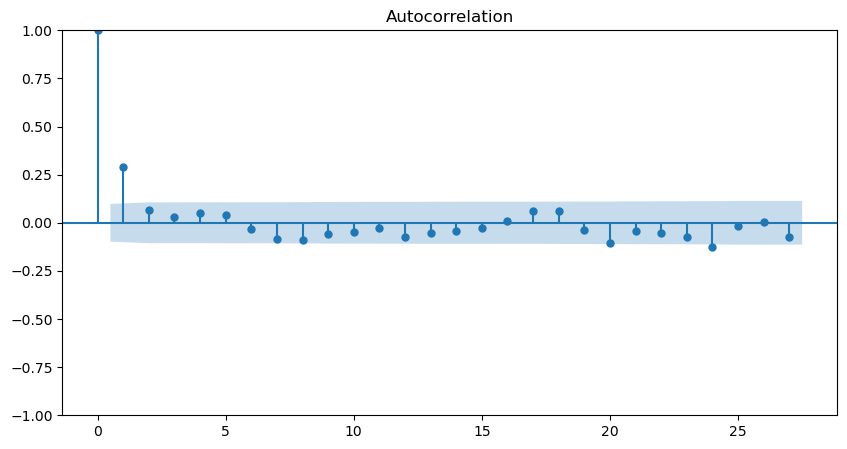

In [23]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(df7['LogRet'].dropna(), ax=ax);

# AutoARIMA

In [24]:
#AutoArima

import pmdarima as pm


In [25]:
def plot_result(model, fulldata, train, test):
  params = model.get_params()
  d = params['order'][1]

  train_pred = model.predict_in_sample(start=d, end=-1)
  test_pred, confint = model.predict(n_periods=Ntest, return_conf_int=True)

  fig, ax = plt.subplots(figsize=(10, 5))
  ax.plot(fulldata.index, fulldata, label='data')
  ax.plot(train.index[d:], train_pred, label='fitted')
  ax.plot(test.index, test_pred, label='forecast')
  ax.fill_between(test.index, \
                  confint[:,0], confint[:,1], \
                  color='red', alpha=0.3)
  ax.legend();

In [26]:
#уберем все NaN
df8 = df7.dropna()

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=-1210.947, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=-1236.806, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=-1236.330, Time=0.09 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=-1234.409, Time=0.14 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=-1234.332, Time=0.15 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=-1233.391, Time=0.18 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=-1238.643, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=-1236.641, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=-1235.146, Time=0.11 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=-1232.438, Time=0.13 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=-1229.464, Time=0.16 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=-1236.641, Time=0.16 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=-1234.643, Time=0.12 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=-1233.140, Time=0.18 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=-1229.782, Time=0.15

C:\Users\Viktor\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Viktor\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


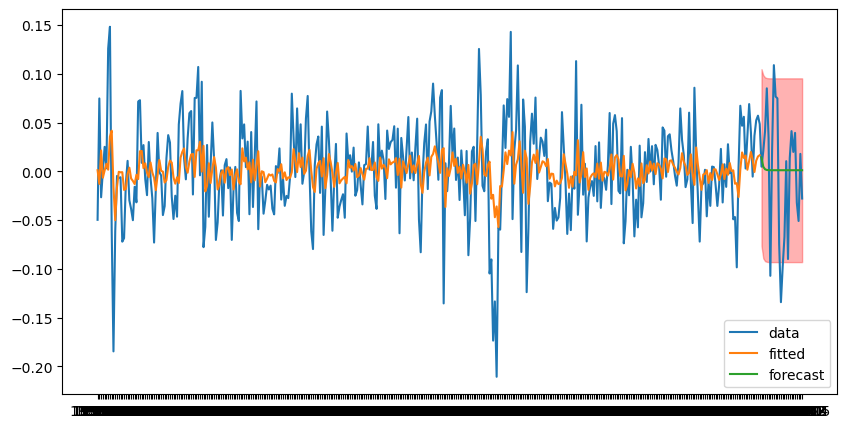

In [27]:
#Полная приведенная модель
train = df8.iloc[:-Ntest]
test = df8.iloc[-Ntest:]


model = pm.auto_arima(train.LogRet,
                      error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=10,
                      max_p = 6, max_d = 4, max_q = 6,
                      seasonal=True, stepwise = False)
plot_result(model, df8["LogRet"], train, test)

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=-1210.947, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=-1236.806, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=-1236.330, Time=0.10 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=-1234.409, Time=0.14 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=-1234.332, Time=0.17 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=-1233.391, Time=0.21 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=-1238.643, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=-1236.641, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=-1235.146, Time=0.11 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=-1232.438, Time=0.13 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=-1229.464, Time=0.16 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=-1236.641, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=-1234.643, Time=0.13 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=-1233.140, Time=0.13 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=-1229.782, Time=0.15

C:\Users\Viktor\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Viktor\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


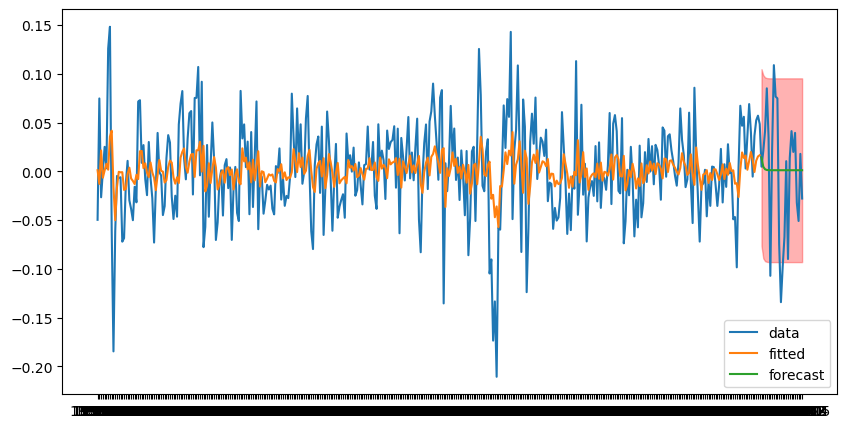

In [28]:
#Полная приведенная модель
df9 = df7.copy()
df9[choose_com] = df9[choose_com].astype(float)

#df9.index.freq = 'MS'

df10 = df9.dropna()

train = df10.iloc[:-Ntest]
test = df10.iloc[-Ntest:]


model = pm.auto_arima(train.LogRet,
                      error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=10,
                      max_p = 6, max_d = 4, max_q = 6,
                      seasonal=True, stepwise = False)
plot_result(model, df10["LogRet"], train, test)

In [29]:
MAPE_ARIMA = mean_absolute_percentage_error((model.predict(Ntest).reset_index()).iloc[:,1], test.reset_index().LogRet)


l = test.reset_index().LogRet.shape[0]
X_naive = np.zeros(l)
X_naive[:]=(train.reset_index().LogRet).iloc[-1]
y_naive = test.reset_index().LogRet
MAPE_Naive = mean_absolute_percentage_error(X_naive, y_naive)

C:\Users\Viktor\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Viktor\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


# LSTM

In [30]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, LSTM, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_absolute_percentage_error


In [31]:
df11 = df7.copy()

In [32]:
df11 = df11.dropna()

In [33]:
# Сделаем столбик с датами для сравнения. 

df11["date"] = pd.date_range(start="1990-02-01", end="2023-05-31", freq='M')

In [34]:
train = df11.iloc[:-Ntest]
test = df11.iloc[-Ntest:]

In [35]:
# Make supervised dataset
series = df11.LogRet.to_numpy()

T = 10
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

# RNN
i = Input(shape=(T, 1))
x = LSTM(24)(i)
x = Dense(1)(x)
model = Model(i, x)

model.summary()

model.compile(
  loss='mse',
  optimizer='adam',
)

r = model.fit(
  Xtrain,
  Ytrain,
  epochs=100,
  validation_data=(Xtest, Ytest)
)

X.shape (390, 10, 1) Y.shape (390,)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 24)                2496      
                                                                 
 dense (Dense)               (None, 1)                 25        
                                                                 
Total params: 2521 (9.85 KB)
Trainable params: 2521 (9.85 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
12/12 [==============================] - 3s 53ms/step - loss: 0.0021 - val_loss: 0.0041
Epoch 2/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0021 - val_loss: 0.0041
Epoch 3/100
12/12 [==============================] - 0s 6m

12/12 [==============================] - 0s 6ms/step - loss: 0.0019 - val_loss: 0.0041
Epoch 75/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0019 - val_loss: 0.0041
Epoch 76/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0019 - val_loss: 0.0041
Epoch 77/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 78/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 79/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0019 - val_loss: 0.0041
Epoch 80/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0019 - val_loss: 0.0041
Epoch 81/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 82/100
12/12 [==============================] - 0s 12ms/step - loss: 0.0019 - val_loss: 0.0041
Epoch 83/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0019 - val_loss: 0.0041
Epoch 84/100

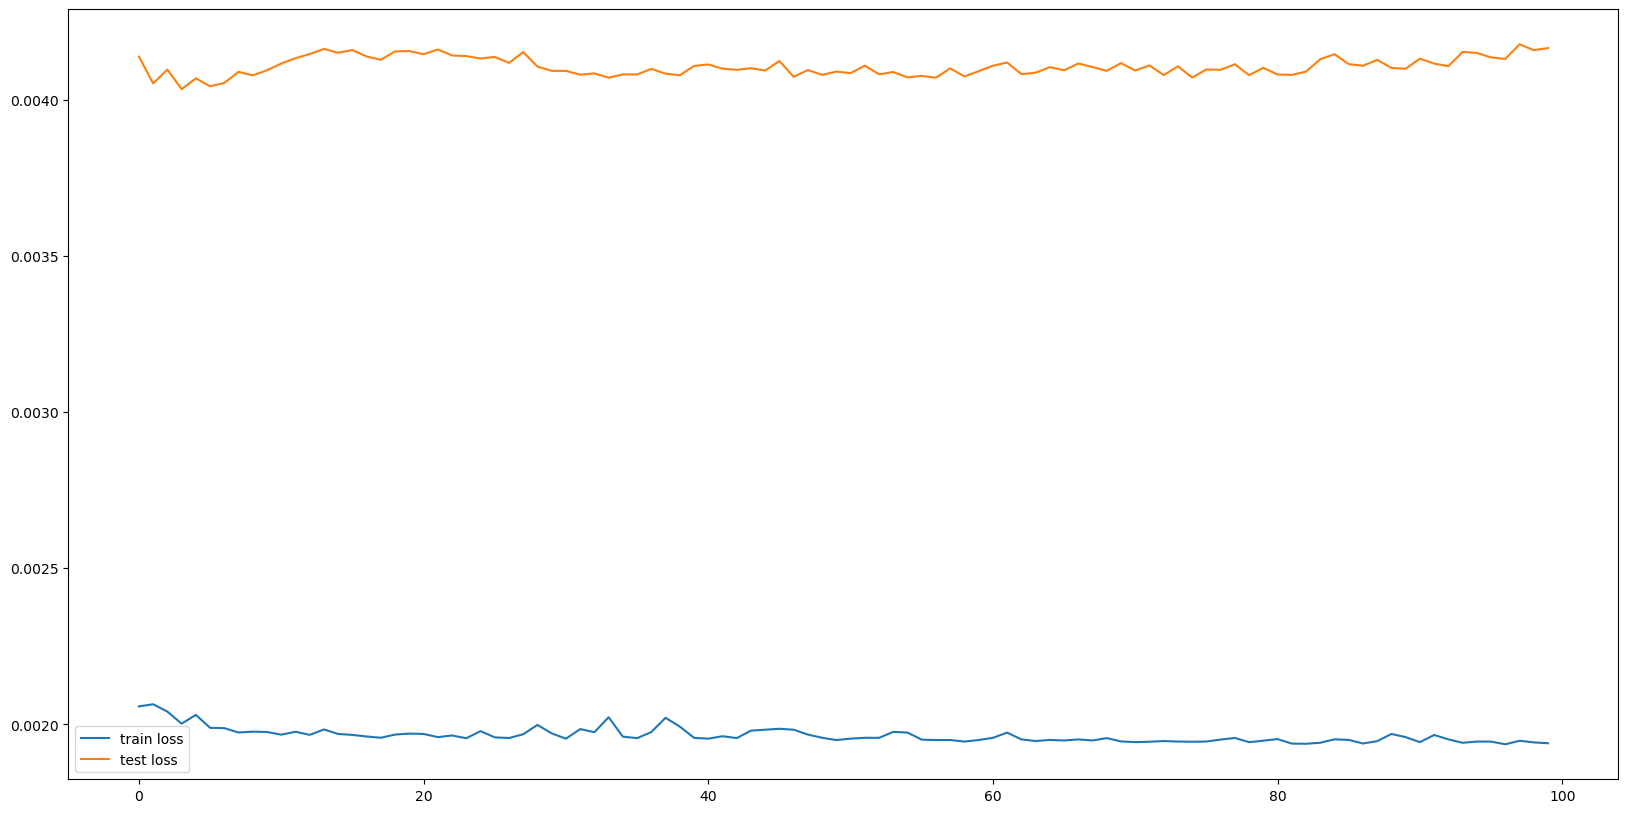

In [36]:
# Пострим функцию потерь для train и test
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();
plt.show()

In [37]:
# логический ряд для индексации строк df
train_idx = df11.date <= train.date[-1]
test_idx = df11.date > train.date[-1]

In [38]:
train_idx[:T+1] = False # first T+1 values are not predictable

In [39]:
last_train = train.iloc[-1]['LogRet']

In [40]:
# multi-step forecast
multistep_predictions = []

# first test input
last_x = Xtest[0]

while len(multistep_predictions) < Ntest:
    p = model.predict(last_x.reshape(1, -1, 1))[0]
  
    # update the predictions list
    multistep_predictions.append(p)
  
    # make the new input
    last_x = np.roll(last_x, -1)
    last_x[-1] = p

1/1 [==============================] - 0s 25ms/step


In [41]:
# save multi-output forecast to dataframe
df11.loc[test_idx, 'multistep'] = last_train + np.cumsum(multistep_predictions)

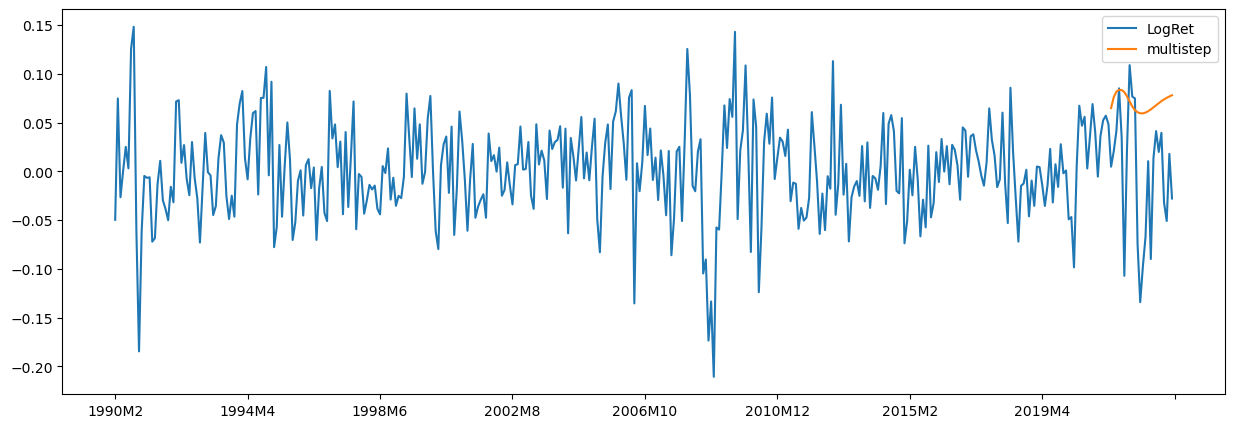

In [42]:
# plot 1-step and multi-step forecast
df11[['LogRet', 'multistep']].plot(figsize=(15, 5));

In [43]:
# MAPE
test_log_pass = df11.iloc[-Ntest:]['LogRet']
MAPE_LSTM = mean_absolute_percentage_error(
    test_log_pass, df11.loc[test_idx, 'multistep'])
print("MAPE LSTM:", MAPE_LSTM)
print("MAPE ARIMA:", MAPE_ARIMA)
print("MAPE Naive:", MAPE_Naive)

MAPE LSTM: 2.3461740152213135
MAPE ARIMA: 41.7069030045678
MAPE Naive: 1.3190591083836438
